In [1]:
import os
import sys
import pandas as pd
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic1"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")
from codebase import get_total_inhabitants_and_willingness

Changed to c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation


In [19]:
within_mins = 1000000
punt = "basis" # ibis, hbo_wo, mbo, basis, highschool, bus, trein
mode = "fiets" # fiets, ebike
location = "Elementary Schools" # Elementary Schools, High Schools, Universities, Train - NS, Train - Local

total, total_willing = get_total_inhabitants_and_willingness(punt1=punt, mode=mode, within_mins=within_mins, location=location, verbose=True)

Loaded file from CSV
Demographics and filtered dataframes do not match in length: 14405 vs 6439109, ignoring missing values
Total inhabitants within 1000000 minutes of basis from buurt: 17806390 of 17811291 = 99.97% of the Netherlands
Total willingness to cycle of those: 508436 of 17806390 = 2.86%


<Figure size 1000x1000 with 0 Axes>

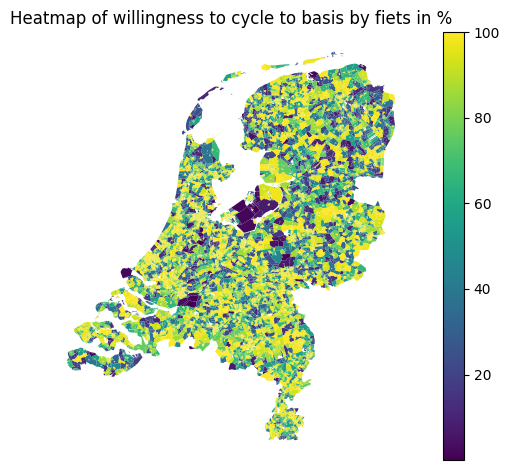

In [20]:
from codebase import plot_willingness_by_buurt_heatmap

plot_willingness_by_buurt_heatmap(punt, mode, location, savename=f"graphics/nl_maps/{punt}_by_{mode}.png")

In [15]:
from codebase import plot_value_by_buurt_heatmap, load_demograhics, demographics_population_column, punt_buurt_code_column, demographics_buurt_code_column

In [16]:
mode = "fiets"
punt1 = "hbo_wo"
location = "Universities"

df_demographics = load_demograhics()
df_demographics[punt_buurt_code_column] = df_demographics[demographics_buurt_code_column]

Loaded file from CSV


c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\codebase\plotting\plots.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', fontsize='small')


<Figure size 1000x1000 with 0 Axes>

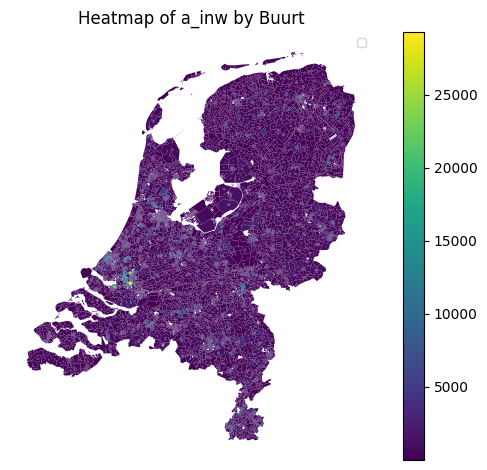

In [18]:

plot_value_by_buurt_heatmap(
    df_punt=df_demographics, 
    col_name=demographics_population_column, 
    show=True, 
    savename="graphics/nl_maps/population_by_buurt.png", 
    cmap='viridis'
)